In [1]:
!wget https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py

--2024-09-04 12:30:41--  https://raw.githubusercontent.com/alexeygrigorev/minsearch/main/minsearch.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3832 (3.7K) [text/plain]
Saving to: ‘minsearch.py’

minsearch.py        100%[===================>]   3.74K  --.-KB/s    in 0s      

2024-09-04 12:30:41 (20.8 MB/s) - ‘minsearch.py’ saved [3832/3832]



In [1]:
import minsearch

In [2]:
import json

In [3]:
import pandas as pd
import numpy as np

In [4]:
from tqdm.auto import tqdm

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Ingestion

In [4]:
with open('data/qna.js', 'rt') as f_in:
    docs_raw = json.load(f_in)

In [5]:
documents = []

for section_dict in docs_raw:
    for doc in section_dict['documents']:
        doc['diet'] = section_dict['section']
        documents.append(doc)

In [6]:
documents[0]

{'question': 'Is a ketogenic diet good for weight loss?',
 'answer': 'Research has shown a ketogenic diet can induce rapid weight loss, partly from water loss but also some fat loss. However, the “weight loss effect becomes similar to other dietary approaches after one year,” according to a recent review of low-carb diets. Taking in less energy than you burn will lead to weight loss. The National Diet & Nutrition Survey reports that on average we get almost 50% of our energy from carbs. Cutting this by at least half is likely to reduce total calorie intake, even if it’s replaced with fats. On the other hand, if you eat more calories from fat than your body needs, it will still be stored as fat.',
 'link': 'https://www.linkedin.com/pulse/20-most-asked-questions-keto-diet-certified-operation-s-management-/',
 'diet': 'keto diet'}

In [16]:
import hashlib

def generate_document_id(doc):
    combined = f"{doc['answer'][:10]}-{doc['question']}-{doc['diet']}"
    hash_object = hashlib.md5(combined.encode())
    hash_hex = hash_object.hexdigest()
    document_id = hash_hex[:8]
    return document_id

In [17]:
for doc in documents:
    doc['id'] = generate_document_id(doc)

In [18]:
documents[3]

{'question': 'What is a good keto meal plan?',
 'answer': 'A good keto meals plan should include the following foods: Eggs: pastured, organic, or conventional all work fine; Poultry: chicken and turkey; Fatty fish: salmon, herring, and mackerel; Meat: beef & organ meats; Full-fat dairy: unsweetened yogurt, butter, and cream; Full-fat cheese: cheddar, mozzarella, brie, goat cheese, and cream cheese; Nuts and seeds: macadamia nuts, almonds, walnuts, pumpkin seeds and flaxseeds; Nut butter: no-sugar-added peanut, almond, and cashew butter; Oils rich in healthy fats: olive oil, avocado oil, and sesame oil; Avocados: whole avocados can be added to almost any meal or snack; Non-starchy vegetables: greens, broccoli, tomatoes, mushrooms, and peppers; Condiments: salt, pepper, vinegar, lemon juice, fresh herbs, and spices.',
 'link': 'https://www.linkedin.com/pulse/20-most-asked-questions-keto-diet-certified-operation-s-management-/',
 'diet': 'keto diet',
 'id': 'c625fd9e'}

In [13]:
from collections import defaultdict

In [14]:
hashes = defaultdict(list)

for doc in documents:
    doc_id = doc['id']
    hashes[doc_id].append(doc)

In [15]:
len(hashes), len(documents)

(79, 79)

In [19]:
# with open('documents-with-ids.json', 'wt') as f_out:
#    json.dump(documents, f_out, indent=2)

In [5]:
with open('documents-with-ids.json', 'r') as f_in:
    documents = json.load(f_in) # first load here

In [8]:
!head documents-with-ids.json

[
  {
    "question": "Is a ketogenic diet good for weight loss?",
    "answer": "Research has shown a ketogenic diet can induce rapid weight loss, partly from water loss but also some fat loss. However, the \u201cweight loss effect becomes similar to other dietary approaches after one year,\u201d according to a recent review of low-carb diets. Taking in less energy than you burn will lead to weight loss. The National Diet & Nutrition Survey reports that on average we get almost 50% of our energy from carbs. Cutting this by at least half is likely to reduce total calorie intake, even if it\u2019s replaced with fats. On the other hand, if you eat more calories from fat than your body needs, it will still be stored as fat.",
    "link": "https://www.linkedin.com/pulse/20-most-asked-questions-keto-diet-certified-operation-s-management-/",
    "diet": "keto diet",
    "id": "973d6f85"
  },
  {
    "question": "What is the keto diet?",


In [32]:
from minsearch import Index

index = Index(
    text_fields=["question", "answer"],
    keyword_fields=["diet"]
)

In [33]:
index.fit(documents)

## RAG flow for MINSEARCH

In [18]:
from openai import OpenAI
client = OpenAI()

In [38]:
def search(q):
    
    boost = {'answer': 3.0}

    results = index.search(
        query = q,
        filter_dict = {'diet': 'keto diet'},
        boost_dict = boost,
        num_results = 5
    )
    return results


    
def build_prompt(query, search_results):
    prompt_template = """
    You're a diet assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.
    
    QUESTION: {question}
    
    CONTEXT: 
    {context}
    """.strip()

    context = ""
    
    for doc in search_results:
        context = context + f"diet: {doc['diet']}\nquestion: {doc['question']}\nanswer: {doc['answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt
def llm(prompt):
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

def rag(query):
    search_results = search(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [16]:
q = "Can keto diet be harmful?"

In [21]:
rag(q)

'Yes, the keto diet can be harmful, especially for people with diabetes. It can pose health risks if followed without medical supervision, as drastically cutting carbs can lead to dangerously low blood sugar (hypoglycemia) for those on medication to lower blood sugar or using insulin. This condition can result in severe health issues such as seizures and loss of consciousness. Additionally, there is no consensus on whether keto is an effective long-term dietary approach for managing diabetes, and it can be difficult to adhere to. Therefore, individuals with type 2 diabetes should work closely with their doctor when considering the keto diet.'

## RAG flow for elasticsearch

### Create embeddings using pretrained models

In [6]:
from sentence_transformers import SentenceTransformer

In [23]:
model = SentenceTransformer("multi-qa-MiniLM-L6-cos-v1")

/usr/local/python/3.12.1/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [8]:
q = "Can keto diet be harmful?"

In [26]:
v = model.encode(q)

In [27]:
len(v)

384

In [11]:
from elasticsearch import Elasticsearch

es_client = Elasticsearch('http://localhost:9200') 

index_settings = {
    "settings": {
        "number_of_shards": 1,
        "number_of_replicas": 0
    },
    "mappings": {
        "properties": {
            "answer": {"type": "text"},
            "diet": {"type": "keyword"},
            "question": {"type": "text"},
            "link": {"type": "text"},
            "id": {"type": "keyword"},
            "question_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "answer_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
            "question_answer_vector": {
                "type": "dense_vector",
                "dims": 384,
                "index": True,
                "similarity": "cosine"
            },
        }
    }
}

index_name = "diets-questions"

es_client.indices.delete(index=index_name, ignore_unavailable=True)
es_client.indices.create(index=index_name, body=index_settings)

ObjectApiResponse({'acknowledged': True, 'shards_acknowledged': True, 'index': 'diets-questions'})

In [13]:
search_query = {

    "field" : "question_vector",
    "query_vector" : v,
    "k" : 5,
    "num_candidates" : 10000,
}

In [12]:
for doc in tqdm(documents):
    question = doc['question']
    answer =  doc['answer']
    qa = question + '    ' + answer
    
    doc['question_vector'] = model.encode(question)
    doc['answer_vector'] = model.encode(answer)
    doc['question_answer_vector'] = model.encode(qa)

100%|█████████████████████████████████████████████████| 79/79 [00:08<00:00,  8.96it/s]


In [13]:
for doc in tqdm(documents):
    es_client.index(index=index_name, document=doc)

100%|█████████████████████████████████████████████████| 79/79 [00:02<00:00, 31.12it/s]


In [35]:
def elastic_search_knn(field, vector, diet):
    knn = {
        "field": field,
        "query_vector": vector,
        "k": 5,
        "num_candidates": 10000,
        "filter": {
            "term": {
                "diet": diet
            }
        }
    }
    
    search_query = {
    "knn": knn,
    "_source": ["answer", "diet", "question", "link", "id"]
    }
    
    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])
    return result_docs


def question_answer_vector_knn(q):
    question = q['question']
    diet = q['diet']

    v_q = model.encode(question)

    return elastic_search_knn('question_answer_vector', v_q, diet)

In [15]:
elastic_search_knn("question_vector", v, "keto diet")

[{'question': 'Is keto dieting safe?',
  'answer': 'The keto diet could cause low blood pressure, kidney stones, constipation, nutrient deficiencies, and an increased risk of heart disease. Strict diets like keto could also cause social isolation or disordered eating. Keto is not safe for those with any conditions involving their pancreas, liver, thyroid, or gallbladder. Someone new to the keto diet can also experience what has been called the “keto flu” with symptoms like upset stomach, dizziness, decreased energy, and mood swings caused by your body adapting to ketosis.',
  'link': 'https://www.linkedin.com/pulse/20-most-asked-questions-keto-diet-certified-operation-s-management-/',
  'diet': 'keto diet',
  'id': 'c85cad6f'},
 {'question': 'Is the Keto Diet Safe to Follow?',
  'answer': "Even though following an extremely high-fat diet can feel like a radical way to eat, 'the research looking at ketosis via diet has not shown any real negative consequences when done in the short term

In [40]:
def elastic_search_knn_combined(vector, diet):
    search_query = {
        "size": 5,
        "query": {
            "bool": {
                "must": [
                    {
                        "script_score": {
                            "query": {
                                "term": {
                                    "diet": diet
                                }
                            },
                            "script": {
                                "source": """
                                    cosineSimilarity(params.query_vector, 'question_vector') + 
                                    cosineSimilarity(params.query_vector, 'answer_vector') + 
                                    cosineSimilarity(params.query_vector, 'question_answer_vector') + 
                                    1
                                """,
                                "params": {
                                    "query_vector": vector
                                }
                            }
                        }
                    }
                ],
                "filter": {
                    "term": {
                        "diet": diet
                    }
                }
            }
        },
        "_source": ["answer", "diet", "question", "link", "id"]
    }

    es_results = es_client.search(
        index=index_name,
        body=search_query
    )
    
    result_docs = []
    
    for hit in es_results['hits']['hits']:
        result_docs.append(hit['_source'])

    return result_docs

### gpt-4o-mini

In [14]:
#!pip install python-dotenv

from dotenv import load_dotenv


from openai import OpenAI

# Load environment variables from .env file
load_dotenv()

# Get the API key from the environment
api_key = os.getenv("OPENAI_API_KEY")

# Initialize the OpenAI client
client = OpenAI(api_key=api_key)



In [15]:
   
def build_prompt(query, search_results):
    prompt_template = """
    You're a diet assistant. Answer the QUESTION based on the CONTEXT from the FAQ database.
    Use only the facts from the CONTEXT when answering the QUESTION.
    
    QUESTION: {question}
    
    CONTEXT: 
    {context}
    """.strip()

    context = ""
    
    for doc in search_results:
        context = context + f"diet: {doc['diet']}\nquestion: {doc['question']}\nanswer: {doc['answer']}\n\n"
    
    prompt = prompt_template.format(question=query, context=context).strip()
    return prompt
    
def llm(prompt):
    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}]
    )
    
    return response.choices[0].message.content

def rag(query: dict) -> str:  
    search_results = question_answer_vector_knn(query)
    prompt = build_prompt(query, search_results)
    answer = llm(prompt)
    return answer

In [41]:
doc_idx = {d['id']: d for d in documents}

doc_idx['973d6f85']['answer']

'Research has shown a ketogenic diet can induce rapid weight loss, partly from water loss but also some fat loss. However, the “weight loss effect becomes similar to other dietary approaches after one year,” according to a recent review of low-carb diets. Taking in less energy than you burn will lead to weight loss. The National Diet & Nutrition Survey reports that on average we get almost 50% of our energy from carbs. Cutting this by at least half is likely to reduce total calorie intake, even if it’s replaced with fats. On the other hand, if you eat more calories from fat than your body needs, it will still be stored as fat.'

In [40]:
answers = {}

In [42]:
for i, rec in enumerate(tqdm(ground_truth)):
    if i in answers:
        continue

    answer_llm = rag(rec)
    doc_id = rec['document']
    original_doc = doc_idx[doc_id]
    answer_orig = original_doc['answer']

    answers[i] = {
        'answer_llm': answer_llm,
        'answer_orig': answer_orig,
        'id': doc_id,
        'question': rec['question'],
        'diet': rec['diet'],
    }

100%|███████████████████████████████████████████████| 395/395 [10:33<00:00,  1.60s/it]


In [44]:
results_gpt4omini = [None] * len(ground_truth)

for i, val in answers.items():
    results_gpt4omini[i] = val.copy()
    results_gpt4omini[i].update(ground_truth[i])

In [45]:
results_gpt4omini[0]

{'answer_llm': "Research has shown that a ketogenic diet can induce rapid weight loss, primarily due to both water loss and some fat loss. However, the weight loss effect tends to become similar to other dietary approaches after one year. The effectiveness of the diet is linked to a reduction in carbohydrate intake, which is likely to lead to a lower overall calorie intake. It's important to note that if more calories from fat are consumed than the body needs, those excess calories will be stored as fat.",
 'answer_orig': 'Research has shown a ketogenic diet can induce rapid weight loss, partly from water loss but also some fat loss. However, the “weight loss effect becomes similar to other dietary approaches after one year,” according to a recent review of low-carb diets. Taking in less energy than you burn will lead to weight loss. The National Diet & Nutrition Survey reports that on average we get almost 50% of our energy from carbs. Cutting this by at least half is likely to reduce

## Save the results of gpt-4o-mini

In [47]:
df_gpt4omini = pd.DataFrame(results_gpt4omini)
df_gpt4omini.to_csv('data/results-gpt4omini.csv', index=False)

In [48]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = model.encode(answer_llm)
    v_orig = model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [49]:
similarity = []

for record in tqdm(results_gpt4omini):
    sim = compute_similarity(record)
    similarity.append(sim)

100%|███████████████████████████████████████████████| 395/395 [00:33<00:00, 11.91it/s]


In [51]:
df_gpt4omini['cosine'] = similarity
df_gpt4omini['cosine'].describe()

count    395.000000
mean       0.776664
std        0.139467
min        0.220716
25%        0.705947
50%        0.798396
75%        0.879593
max        1.000000
Name: cosine, dtype: float64

In [53]:
import seaborn as sns

/tmp/ipykernel_7002/159869048.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_gpt4omini['cosine'])


<Axes: xlabel='cosine', ylabel='Density'>

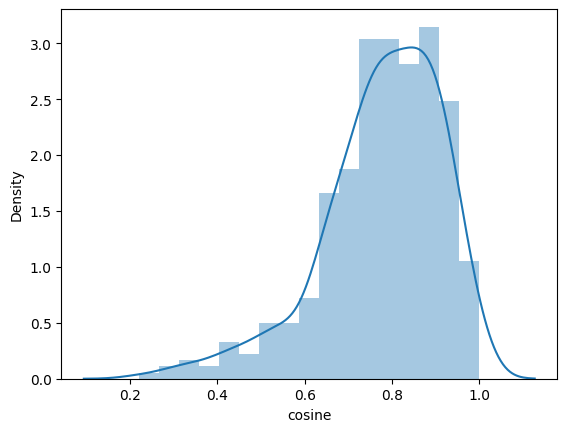

In [54]:
sns.distplot(df_gpt4omini['cosine'])

In [39]:
rag(ground_truth[0])

"Research has shown that a ketogenic diet can induce rapid weight loss, partly due to water loss and some fat loss. However, a recent review indicates that the weight loss effect becomes similar to other dietary approaches after one year. The principle behind weight loss is taking in less energy than you burn, and since the National Diet & Nutrition Survey shows that nearly 50% of our energy typically comes from carbs, cutting carb intake significantly could lead to a reduction in total calorie intake. Nonetheless, if fat consumption exceeds the body's energy needs, the excess will still be stored as fat."

In [31]:
v = model.encode(ground_truth[0]['question'])

'Research has shown a ketogenic diet can induce rapid weight loss, partly from water loss but also some fat loss. However, the “weight loss effect becomes similar to other dietary approaches after one year,” according to a recent review of low-carb diets. Taking in less energy than you burn will lead to weight loss. The National Diet & Nutrition Survey reports that on average we get almost 50% of our energy from carbs. Cutting this by at least half is likely to reduce total calorie intake, even if it’s replaced with fats. On the other hand, if you eat more calories from fat than your body needs, it will still be stored as fat.'

## Generation of ground truth data

In [24]:
prompt_template = """
You emulate a person who wants to know more about specific diet.
Formulate 5 questions this person might ask based on a FAQ record. The record
should contain the answer to the questions, and the questions should be complete and not too short.
If possible, use as fewer words as possible from the record. 

The record:

diet: {diet}
question: {question}
answer: {answer}

Provide the output in parsable JSON without using code blocks:

["question1", "question2", ..., "question5"]
""".strip()

In [25]:
def generate_questions(doc):
    prompt = prompt_template.format(**doc)

    response = client.chat.completions.create(
        model='gpt-4o-mini',
        messages=[{"role": "user", "content": prompt}]
    )

    json_response = response.choices[0].message.content
    return json_response

In [27]:
results = {}
for doc in tqdm(documents): 
    doc_id = doc['id']
    if doc_id in results:
        continue

    questions = generate_questions(doc)
    results[doc_id] = questions

100%|█████████████████████████████████████████████████████| 79/79 [01:30<00:00,  1.15s/it]


In [ ]:
# Save to a file or use as needed
# with open('questions.json', 'w') as json_file:
#    json.dump(results, json_file, indent=2)

In [52]:
with open('questions.json', 'r') as json_file:
    json_data = json.load(json_file)

In [53]:
parsed_results = {}

for doc_id, json_questions in json_data.items():
    parsed_results[doc_id] = json.loads(json_questions)

In [54]:
doc_index = {d['id']: d for d in documents}
final_results = []

for doc_id, questions in parsed_results.items():
    course = doc_index[doc_id]['diet']
    for q in questions:
        final_results.append((q, course, doc_id))

df = pd.DataFrame(final_results, columns=['question', 'diet', 'id'])
df.to_csv('ground-truth-data.csv', index=False)
!head ground-truth-data.csv

question,diet,document
What evidence exists to support the effectiveness of a ketogenic diet for weight loss?,keto diet,973d6f85
How does the initial weight loss on a ketogenic diet compare to other diets over time?,keto diet,973d6f85
What is the impact of carbohydrate intake on overall calorie consumption in a ketogenic diet?,keto diet,973d6f85
Can excess fat consumption on a ketogenic diet lead to weight gain?,keto diet,973d6f85
What role do water loss and fat loss play in the rapid weight loss associated with ketogenic diets?,keto diet,973d6f85
Can you explain the main principles of the ketogenic diet?,keto diet,f5ef0117
How does the keto diet affect carbohydrate and fat intake?,keto diet,f5ef0117
What metabolic state does the body enter when following the keto diet?,keto diet,f5ef0117
What are the benefits of having elevated ketones in the body?,keto diet,f5ef0117


## Retrieval evaluation for minsearch

In [18]:
df_question = pd.read_csv('data/ground-truth-data.csv')

In [24]:
df_question.head()

,question,diet,document
0,What evidence exists to support the effectiven...,keto diet,973d6f85
1,How does the initial weight loss on a ketogeni...,keto diet,973d6f85
2,What is the impact of carbohydrate intake on o...,keto diet,973d6f85
3,Can excess fat consumption on a ketogenic diet...,keto diet,973d6f85
4,What role do water loss and fat loss play in t...,keto diet,973d6f85


In [19]:
ground_truth = df_question.to_dict(orient='records')

In [41]:
ground_truth[0]['question']

'What evidence exists to support the effectiveness of a ketogenic diet for weight loss?'

In [20]:
def hit_rate(relevance_total):
    cnt = 0

    for line in relevance_total:
        if True in line:
            cnt = cnt + 1

    return cnt / len(relevance_total)
    
def mrr(relevance_total):
    total_score = 0.0

    for line in relevance_total:
        for rank in range(len(line)):
            if line[rank] == True:
                total_score = total_score + 1 / (rank + 1)

    return total_score / len(relevance_total)

In [35]:
def minsearch_search(query):
    boost = {}

    results = index.search(
        query=query,
        filter_dict={},
        boost_dict=boost,
        num_results=5
    )

    return results


In [36]:
def evaluate(ground_truth, search_function):
    relevance_total = []

    for q in tqdm(ground_truth):
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [39]:
evaluate(ground_truth, lambda q: search(q['question']))


100%|██████████████████████████████████████████████| 395/395 [00:00<00:00, 588.60it/s]


{'hit_rate': 0.7569620253164557, 'mrr': 0.5881434599156119}

minsearch result on question : {'hit_rate': 0.7569620253164557, 'mrr': 0.5881434599156119}


In [46]:
len(df_question)

395

## Retrieval evaluation for elasticsearch

In [20]:
df_question = pd.read_csv('data/ground-truth-data.csv')

In [21]:
ground_truth = df_question.to_dict(orient='records')

In [26]:
ground_truth[0]

{'question': 'What evidence exists to support the effectiveness of a ketogenic diet for weight loss?',
 'diet': 'keto diet',
 'document': '973d6f85'}

In [62]:
def evaluate(ground_truth, search_function):
    relevance_total = []

    check_l = []

    i=0

    for q in tqdm(ground_truth):
        
        doc_id = q['document']
        results = search_function(q)
        relevance = [d['id'] == doc_id for d in results]
        relevance_total.append(relevance)
        if True not in relevance:
            check_l.append(i)
            
        i+=1
        
    print(check_l)

    return {
        'hit_rate': hit_rate(relevance_total),
        'mrr': mrr(relevance_total),
    }

In [47]:
def search_es(q_gt, query_vector):
    question = q_gt['question']
    diet = q_gt['diet']
    
    v_q = model.encode(question)

    return  elastic_search_knn(query_vector, v_q, diet)

In [63]:
evaluate(ground_truth, lambda q: search_es(q, "question_answer_vector"))

100%|███████████████████████████████████████████████| 395/395 [00:08<00:00, 48.52it/s]

[8, 9, 11, 13, 14, 22, 37, 38, 39, 41, 42, 44, 49, 78, 81, 84, 86, 87, 88, 97, 98, 99, 102, 106, 107, 108, 109, 111, 119, 129, 154, 156, 158, 159, 163, 171, 182, 184, 191, 194, 201, 219, 224, 226, 228, 237, 244, 246, 247, 248, 252, 253, 259, 264, 266, 278, 281, 282, 284, 288, 293, 294, 298, 309, 326, 327, 328, 338, 348, 363, 366, 367, 368, 392]


{'hit_rate': 0.8126582278481013, 'mrr': 0.649282700421941}

Vector search result on "query_vector" = "question_answer_vector" : {'hit_rate': 0.8126582278481013, 'mrr': 0.649282700421941}


Vector search result on "query_vector" = "answer_vector" : {'hit_rate': 0.7873417721518987, 'mrr': 0.609662447257384}


Vector search result on "query_vector" = "question_vector" : {'hit_rate': 0.6379746835443038, 'mrr': 0.4820675105485234}



In [42]:
def search_es_combined(q_gt):
    question = q_gt['question']
    diet = q_gt['diet']
    
    v_q = model.encode(question)

    return  elastic_search_knn_combined(v_q, diet)

In [43]:
evaluate(ground_truth, lambda q: search_es_combined(q))

100%|███████████████████████████████████████████████| 395/395 [00:09<00:00, 41.91it/s]


{'hit_rate': 0.7949367088607595, 'mrr': 0.6284810126582281}

Vector search result using combined vector : {'hit_rate': 0.7949367088607595, 'mrr': 0.6284810126582281}

In [57]:
l= ['f5ef0117', 'f5ef0117', '5ae7a1b5', '5ae7a1b5', '5ae7a1b5', '9ec6094c', 'd575b7e4', 'd575b7e4', 'd575b7e4', 'c85cad6f', 'c85cad6f', 'c85cad6f', '6d61cf05', '6334339f', '418404aa', '418404aa', '42c7343f', '42c7343f', '42c7343f', '999384c5', '999384c5', '999384c5', 'ddbe583f', '9fca21c3', '9fca21c3', '9fca21c3', '9fca21c3', 'b9f44140', '3774fee7', '3e26bc72', 'e31ce8e1', '0cdef088', '0cdef088', '0cdef088', '2c0d4643', '7ffa1080', 'd3a79a81', 'd3a79a81', '009bb121', '009bb121', 'abebc5be', '916a689d', '391b4595', '17524276', '17524276', '7ae8e3d8', '5f652986', '6c719104', '6c719104', '6c719104', '4f3c281b', '4f3c281b', '343284ad', 'ad920ee2', '79b89408', 'efb5f0ee', '6d03704c', '6d03704c', '6d03704c', '6b3c892f', 'f68dfdd8', 'f68dfdd8', '55f7a1ca', '15475b16', '8b478b1d', '8b478b1d', '8b478b1d', '591b5ae1', '27b3cfe8', '5013f1cb', '2014aa8f', '2014aa8f', '2014aa8f', 'f643b4c6']

In [58]:
len(l)

74

In [54]:
len(ground_truth)

395

In [35]:
ground_truth[8]['diet']

'keto diet'

In [65]:
res = search_es(ground_truth[8], "question_answer_vector")

In [66]:
res

[{'question': 'What are the benefits of a keto diet?',
  'answer': 'Supports weight loss, Improves acne, May reduce the risk of certain cancers, May improve heart health, May protect brain function, Potentially reduces seizures, Improves PCOS symptoms, Risks and complications',
  'link': 'https://www.linkedin.com/pulse/20-most-asked-questions-keto-diet-certified-operation-s-management-/',
  'diet': 'keto diet',
  'id': 'e16ef5cc'},
 {'question': 'What About High Cholesterol and Heart Attacks From All This Fat?',
  'answer': 'The current literature indicates that the keto diet typically increases HDL cholesterol levels, increases LDL cholesterol levels (primarily by increasing LDL particle size), and decreases triglyceride levels. Keto eating can improve several other risk factors for heart disease, including high blood pressure, type 2 diabetes, and abdominal obesity. However, it is crucial to monitor your health when making any major dietary change.',
  'link': 'https://www.ruled.me/k

In [68]:
result = [item for item in documents if item['id'] == 'f5ef0117']


## LLM as judge

In [5]:
df_gpt4omini = pd.read_csv('data/results-gpt4omini.csv')

In [11]:
df_gpt4omini.head()

,answer_llm,answer_orig,id,question,diet,document
0,Research has shown that a ketogenic diet can i...,Research has shown a ketogenic diet can induce...,973d6f85,What evidence exists to support the effectiven...,keto diet,973d6f85
1,The initial weight loss on a ketogenic diet is...,Research has shown a ketogenic diet can induce...,973d6f85,How does the initial weight loss on a ketogeni...,keto diet,973d6f85
2,"In a ketogenic diet, carbohydrate intake is si...",Research has shown a ketogenic diet can induce...,973d6f85,What is the impact of carbohydrate intake on o...,keto diet,973d6f85
3,"Yes, excess fat consumption on a ketogenic die...",Research has shown a ketogenic diet can induce...,973d6f85,Can excess fat consumption on a ketogenic diet...,keto diet,973d6f85
4,The rapid weight loss associated with ketogeni...,Research has shown a ketogenic diet can induce...,973d6f85,What role do water loss and fat loss play in t...,keto diet,973d6f85


In [8]:
dict_gpt4omini = df_gpt4omini.to_dict(orient = 'records')

In [9]:
record = dict_gpt4omini[0]

In [10]:
prompt1_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer compared to the original answer provided.
Based on the relevance and similarity of the generated answer to the original answer, you will classify
it as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Original Answer: {answer_orig}
Generated Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the original
answer and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [17]:
prompt = prompt1_template.format(**record)

In [19]:
ans = llm(prompt)

In [21]:
json.loads(ans)

{'Relevance': 'RELEVANT',
 'Explanation': "The generated answer closely mirrors the original answer, accurately summarizing key points about the ketogenic diet's effects on weight loss, the role of carbohydrate intake, and the importance of calorie balance. It captures both the immediate and long-term efficacy of the diet as outlined in the original."}

In [29]:
ls_ans = []

for rec in tqdm(dict_gpt4omini):
    prompt = prompt1_template.format(**rec)
    ans = llm(prompt)
    ls_ans.append(ans)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [07:35<00:00,  1.15s/it]


In [31]:
json_evaluations = []

for i, str_eval in enumerate(ls_ans):
    json_eval = json.loads(str_eval)
    json_evaluations.append(json_eval)

In [32]:
df_evaluations = pd.DataFrame(json_evaluations)

In [37]:
df_evaluations.Relevance.value_counts()

Relevance
RELEVANT           299
PARTLY_RELEVANT     96
Name: count, dtype: int64

In [38]:
df_evaluations.to_csv('data/res_evaluations_with_gpt-4o-mini.csv', index=False)

In [39]:
prompt2_template = """
You are an expert evaluator for a Retrieval-Augmented Generation (RAG) system.
Your task is to analyze the relevance of the generated answer to the given question.
Based on the relevance of the generated answer, you will classify it
as "NON_RELEVANT", "PARTLY_RELEVANT", or "RELEVANT".

Here is the data for evaluation:

Question: {question}
Generated Answer: {answer_llm}

Please analyze the content and context of the generated answer in relation to the question
and provide your evaluation in parsable JSON without using code blocks:

{{
  "Relevance": "NON_RELEVANT" | "PARTLY_RELEVANT" | "RELEVANT",
  "Explanation": "[Provide a brief explanation for your evaluation]"
}}
""".strip()

In [40]:
ls_ans_2 = []

for rec in tqdm(dict_gpt4omini):
    prompt = prompt2_template.format(**rec)
    ans = llm(prompt)
    ls_ans_2.append(ans)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 395/395 [06:40<00:00,  1.01s/it]


In [41]:
json_evaluations_2 = []

for i, str_eval in enumerate(ls_ans_2):
    json_eval = json.loads(str_eval)
    json_evaluations_2.append(json_eval)

df_evaluations_2 = pd.DataFrame(json_evaluations_2)
df_evaluations_2.Relevance.value_counts()

Relevance
RELEVANT           382
PARTLY_RELEVANT     13
Name: count, dtype: int64

In [42]:
df_evaluations_2.to_csv('data/res_evaluations_with_gpt-4o-mini_2.csv', index=False)

In [45]:
df_evaluations_2[df_evaluations_2.Relevance == 'PARTLY_RELEVANT']


,Relevance,Explanation
12,PARTLY_RELEVANT,The generated answer addresses a specific grou...
41,PARTLY_RELEVANT,The generated answer discusses individuals who...
50,PARTLY_RELEVANT,The generated answer correctly identifies gluc...
66,PARTLY_RELEVANT,The generated answer addresses the question ab...
68,PARTLY_RELEVANT,The generated answer mentions baked goods that...
78,PARTLY_RELEVANT,The generated answer provides some information...
107,PARTLY_RELEVANT,The generated answer acknowledges that there i...
292,PARTLY_RELEVANT,The generated answer discusses the impact of e...
318,PARTLY_RELEVANT,The generated answer addresses the consumption...
362,PARTLY_RELEVANT,The generated answer focuses on food items to ...


In [46]:
dict_gpt4omini[12]

{'answer_llm': 'A ketogenic diet might be advised for individuals with uncontrolled epilepsy, as it originated as a therapeutic diet to help control seizures in those patients.',
 'answer_orig': 'While the ketogenic diet may be recommended for some people with uncontrolled epilepsy, the high-fat content — and especially the high level of unhealthy saturated fat — combined with limits on nutrient-rich fruits, veggies, and grains is a concern for long-term heart health.',
 'id': '5ae7a1b5',
 'question': 'Who might be advised to follow a ketogenic diet?',
 'diet': 'keto diet',
 'document': '5ae7a1b5'}